# Jax goes BRRRRR



*   No side effects
*   compiles with shapes



In [ ]:
import jax
import jax.numpy as jnp

## NUMPY

### Creating Arrays and Accelerators

In [ ]:
a = jnp.zeros((2, 5), dtype=jnp.float32)
a

Array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
b = jnp.arange(6)
b

Array([0, 1, 2, 3, 4, 5], dtype=int32)

In [ ]:
b.__class__

jaxlib.xla_extension.ArrayImpl

In [ ]:
b.device

CpuDevice(id=0)

> No matter which device the array is on, its always ArrayImpl, (used to be DeviceArray in old Jax)

In [ ]:
b_cpu = jax.device_get(b)
b_cpu.__class__

numpy.ndarray

In [ ]:
b_gpu = jax.device_put(b)
b_gpu.__class__, b_gpu.device

(jaxlib.xla_extension.ArrayImpl, CpuDevice(id=0))

In [ ]:
ans = b_cpu + b_gpu
ans.__class__, ans.device

(jaxlib.xla_extension.ArrayImpl, CpuDevice(id=0))

> when cpu array + gpu array, the computation happens in GPU (cpu array is transferred to GPU for computing)

Jax does async dispatch !

### Immutable arrays

In [ ]:
b_new = b.at[0].set(100)
b_new

Array([100,   1,   2,   3,   4,   5], dtype=int32)

In [ ]:
print(f'{b=}, {b_new=}')

b=Array([0, 1, 2, 3, 4, 5], dtype=int32), b_new=Array([100,   1,   2,   3,   4,   5], dtype=int32)


### RNG

In [ ]:
rng = jax.random.key(42)

In [ ]:
jax_random_number_1 = jax.random.normal(rng, 1)
jax_random_number_2 = jax.random.normal(rng, 1)
print(f'{jax_random_number_1=}, {jax_random_number_2=}')

jax_random_number_1=Array([-0.02830462], dtype=float32), jax_random_number_2=Array([-0.02830462], dtype=float32)


In [ ]:
rng, new_key, new_key2 = jax.random.split(rng, num=3)

jax_random_number_1 = jax.random.normal(rng, 1)
jax_random_number_2 = jax.random.normal(new_key, 1)
print(f'{jax_random_number_1=}, {jax_random_number_2=}')

jax_random_number_1=Array([0.07592554], dtype=float32), jax_random_number_2=Array([0.60576403], dtype=float32)


> After splitting a key, every new key is unique and different from old key!

## Function transformations

***don’t write code with side-effects.***

but not everything should satisfy this
> loading or saving of models, the logging, or the data generation

In [ ]:
def simple_graph(x):
    x += 2
    x  = x **2
    x += 3
    y = x.mean()
    return y

inp = jnp.arange(3, dtype=jnp.float32)
output = simple_graph(inp)
print(f'{inp=}')
print(f'{output=}')

inp=Array([0., 1., 2.], dtype=float32)
output=Array(12.666667, dtype=float32)


In [ ]:
jax.make_jaxpr(simple_graph)(inp)

{ lambda ; a:f32[3]. let
    b:f32[3] = add a 2.0
    c:f32[3] = integer_pow[y=2] b
    d:f32[3] = add c 3.0
    e:f32[] = reduce_sum[axes=(0,)] d
    f:f32[] = div e 3.0
  in (f,) }

```
jaxpr ::= { lambda Var* ; Var+.
            let Eqn*
            in  [Expr+] }
```

`Var*` are constants  
`Var+` are inputs  
`Eqn*` list of equations  
`Expr+` outputs

In [ ]:
## example of a function with side effect

global_list = []
def norm(x):
    global_list.append(x)
    x = x**2
    n = x.sum()
    n = jnp.sqrt(n)
    return n

jax.make_jaxpr(norm)(inp)

{ lambda ; a:f32[3]. let
    b:f32[3] = integer_pow[y=2] a
    c:f32[] = reduce_sum[axes=(0,)] b
    d:f32[] = sqrt c
  in (d,) }

### Automatic differentiation





In [ ]:
grad_function = jax.grad(simple_graph)
gradients = grad_function(inp)
print(f'{gradients=}')

gradients=Array([1.3333334, 2.       , 2.6666667], dtype=float32)


In [ ]:
jax.make_jaxpr(grad_function)(inp)

{ lambda ; a:f32[3]. let
    b:f32[3] = add a 2.0
    c:f32[3] = integer_pow[y=2] b
    d:f32[3] = integer_pow[y=1] b
    e:f32[3] = mul 2.0 d
    f:f32[3] = add c 3.0
    g:f32[] = reduce_sum[axes=(0,)] f
    _:f32[] = div g 3.0
    h:f32[] = div 1.0 3.0
    i:f32[3] = broadcast_in_dim[
      broadcast_dimensions=()
      shape=(3,)
      sharding=None
    ] h
    j:f32[3] = mul i e
  in (j,) }

> Jax creates a seperate function for gradients

In [ ]:
# used a lot !

val_grad_function = jax.value_and_grad(simple_graph)
val_grad_function(inp)

(Array(12.666667, dtype=float32),
 Array([1.3333334, 2.       , 2.6666667], dtype=float32))

### JIT!

In [ ]:
jitted_function = jax.jit(simple_graph)

In [ ]:
rng, normal_rng = jax.random.split(rng)
large_input = jax.random.normal(normal_rng, (1_000))
_ = jitted_function(large_input) # initial run to compile

In [ ]:
%%timeit

simple_graph(large_input).block_until_ready()

2.04 ms ± 887 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
jitted_function(large_input).block_until_ready()

190 µs ± 99.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
jitted_grad_function = jax.jit(grad_function)
_ = jitted_grad_function(large_input) # initial run

In [ ]:
%%timeit
grad_function(large_input).block_until_ready()

11.2 ms ± 7.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
jitted_grad_function(large_input).block_until_ready()

151 µs ± 30 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


- jit the largest possible chunk of computation to give the compiler maximum freedom.

- if an input argument cannot be traced, or you need to use loops that depend on input arguments. -> NOT STRAIGHT FORWARD TO USE JIT

## Neural Network

In [ ]:
import flax
from flax import linen as nn

In [ ]:
# Example module

class MyModule(nn.Module):
    # Some dataclass attributes, like hidden dimension, number of layers, etc. of the form:
    # varname : vartype

    def setup(self):
        # Flax uses "lazy" initialization. This function is called once before you
        # call the model, or try to access attributes. In here, define your submodules etc.
        pass

    def __call__(self):
        # Function for performing the calculation of the module.
        pass

In [ ]:
class SimpleClassifier(nn.Module):
    num_hidden: int
    num_outputs: int

    def setup(self):
        self.linear1 = nn.Dense(features=self.num_hidden)
        self.linear2 = nn.Dense(features=self.num_outputs)

    def __call__(self, x):
        x = self.linear1(x)
        x = nn.tanh(x)
        x = self.linear2(x)
        return x

In [ ]:
class SimpleClassifierCompact(nn.Module):
    num_hidden: int
    num_outputs: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=self.num_hidden)(x)
        x = nn.tanh(x)
        x = nn.Dense(features=self.num_outputs)(x)
        return x

In [ ]:
model = SimpleClassifier(num_hidden=8, num_outputs=1)
print(model)

SimpleClassifier(
    # attributes
    num_hidden = 8
    num_outputs = 1
)


In [ ]:
rng, input_rng, init_rng = jax.random.split(rng, num=3)
inp = jax.random.normal(input_rng, (8, 2))
params = model.init(init_rng, inp)

print(params)

{'params': {'linear1': {'kernel': Array([[ 0.2358262 ,  1.1846783 , -0.8173433 , -0.5974849 ,  1.5113541 ,
         0.46746165, -1.4007498 ,  0.06445124],
       [-1.3228476 , -0.46699226, -1.0662045 ,  0.11042926, -1.1234415 ,
         1.1816872 ,  0.2501724 ,  0.43124083]], dtype=float32), 'bias': Array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, 'linear2': {'kernel': Array([[ 0.3490574 ],
       [-0.17485276],
       [ 0.21137303],
       [-0.5151711 ],
       [ 0.11410474],
       [ 0.30252907],
       [-0.08755054],
       [ 0.29612565]], dtype=float32), 'bias': Array([0.], dtype=float32)}}}


In [ ]:
model.apply(params, inp)

Array([[-0.05129167],
       [-0.13886493],
       [ 0.56730676],
       [-0.37633365],
       [ 0.39997315],
       [-0.42515507],
       [ 0.5623411 ],
       [-0.21240012]], dtype=float32)

### Data

In [ ]:
import torch.utils.data as data

In [ ]:
import numpy as np

class XORDataset(data.Dataset):

    def __init__(self, size, seed, std=0.1):
        super().__init__()
        self.size = size
        self.np_rng = np.random.RandomState(seed=seed)
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        data = self.np_rng.randint(low=0, high=2, size=(self.size, 2)).astype(np.float32)
        label = (data.sum(axis=1) == 1).astype(np.int32)

        data += self.np_rng.normal(loc=0.0, scale=self.std, size=(self.size, 2))

        self.data = data
        self.label = label

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        data_point = self.data[idx]
        data_label = self.label[idx]

        return data_point, data_label

In [ ]:
dataset = XORDataset(size=200, seed=42)
print(f'len of dataset: {len(dataset)}')
print(f'First data point: {dataset[0]}')

len of dataset: 200
First data point: (array([-0.06800247,  1.0232254 ], dtype=float32), np.int32(1))


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

<ipython-input-37-1364b0f27049>:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [ ]:
def visualize_samples(data, label):
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolors="#333", label="class 1")
    plt.title("Dataset Samples")
    plt.ylabel('$x_2$')
    plt.xlabel('$x_1$')
    plt.legend()

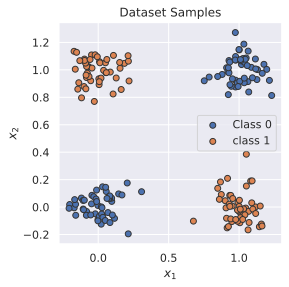

In [ ]:
visualize_samples(dataset.data, dataset.label)

### data loaders

In [ ]:
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=numpy_collate)

In [ ]:
data_inputs, data_labels = next(iter(data_loader))

print(f'data inputs: {data_inputs.shape} \n {data_inputs}')
print(f'data labels: {data_labels.shape} \n {data_labels}')

data inputs: (8, 2) 
 [[-0.16694053  0.05433602]
 [ 0.9446351   0.8802122 ]
 [ 0.9300274   0.02139799]
 [ 0.02809919 -0.06226995]
 [ 0.09540018  0.06513912]
 [ 1.0366598   0.906012  ]
 [-0.13776694  0.9062175 ]
 [ 0.9992027   1.1479944 ]]
data labels: (8,) 
 [0 0 1 0 0 0 1 0]


### Optimizers

In [ ]:
import optax

In [ ]:
optimizer = optax.sgd(learning_rate=1e-1)

In [ ]:
from flax.training import train_state

In [ ]:
model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

### Loss function

In [ ]:
def calculate_loss_acc(state, params, batch):
    data_input, labels = batch
    logits = state.apply_fn(params, data_input).squeeze(axis=-1)
    pred_labels = (logits > 0).astype(jnp.float32)
    loss = optax.sigmoid_binary_cross_entropy(logits, labels).mean()
    acc = (pred_labels == labels).mean()

    return loss, acc

In [ ]:
batch = next(iter(data_loader))

calculate_loss_acc(model_state, model_state.params, batch)

(Array(0.5923245, dtype=float32), Array(0.75, dtype=float32))

### Efficient training and validation

In [ ]:
@jax.jit
def train_step(state, batch):
    grad_fn = jax.value_and_grad(calculate_loss_acc,
                                 argnums=1,
                                 has_aux=True)
    (loss, acc), grads = grad_fn(state, state.params, batch)
    state = state.apply_gradients(grads=grads) # it is a named param
    return state, loss, acc

In [ ]:
@jax.jit
def eval_step(state, batch):
    _, acc = calculate_loss_acc(state, state.params, batch)
    return acc

### Training

In [ ]:
train_dataset = XORDataset(2500, 42)
train_data_loader = data.DataLoader(train_dataset,
                                    batch_size=128,
                                    shuffle=True,
                                    collate_fn=numpy_collate)

In [ ]:
from tqdm.auto import tqdm

def train_model(state, data_loader, num_epochs=50):
    for epoch in tqdm(range(num_epochs)):
        for batch in data_loader:
            state, loss, acc = train_step(state, batch)

    return state


In [ ]:
trained_model_state = train_model(model_state, train_data_loader, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

### checkpointing / saving

> outdated code below, change to obrax

https://flax-linen.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html

In [ ]:
from flax.training import checkpoints

In [ ]:
!pwd

/content


In [ ]:
checkpoints.save_checkpoint(ckpt_dir='/content/my_checkpoints/',  # Folder to save checkpoint in
                            target=trained_model_state,  # What to save. To only save parameters, use model_state.params
                            step=100,  # Training step or other metric to save best model on
                            prefix='my_model',  # Checkpoint file name prefix
                            overwrite=True   # Overwrite existing checkpoint files
                           )

'/content/my_checkpoints/my_model100'

In [ ]:
loaded_model_state = checkpoints.restore_checkpoint(
    ckpt_dir='/content/my_checkpoints/',
    target=model_state,
    prefix='my_model'
)

loaded_model_state

TrainState(step=2000, apply_fn=<bound method Module.apply of SimpleClassifier(
    # attributes
    num_hidden = 8
    num_outputs = 1
)>, params={'params': {'linear1': {'kernel': Array([[ 2.384137  ,  2.5866644 , -1.7826445 , -0.29721934,  2.637906  ,
         2.2365346 , -1.941201  ,  0.26934454],
       [-3.38302   , -1.6616682 , -1.6930373 ,  0.7953639 , -1.7184888 ,
         2.1297    ,  0.8148249 ,  0.3801095 ]], dtype=float32), 'bias': Array([-0.8074513 ,  0.5851127 ,  0.06190493, -0.07146921,  0.6141333 ,
       -0.4144196 , -0.08219747,  0.21098277], dtype=float32)}, 'linear2': {'kernel': Array([[ 4.7263002 ],
       [-2.406348  ],
       [-2.0669682 ],
       [-0.78201866],
       [-2.2815604 ],
       [ 2.9447079 ],
       [ 1.190672  ],
       [ 0.12051622]], dtype=float32), 'bias': Array([0.78504246], dtype=float32)}}}, tx=GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x7c2d70a6ae80>, update=<function chain.<locals>.update_fn at 0x7c2d70a6b060>),

In [ ]:
%%capture

!pip install orbax-checkpoint

In [ ]:
import orbax
from flax.training import orbax_utils

In [ ]:
ckpt = {
    'model': trained_model_state
}
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(ckpt)
orbax_checkpointer.save('/content/my_checkpoints/single_save2', ckpt, save_args=save_args)

In [ ]:
raw_restored = orbax_checkpointer.restore('/content/my_checkpoints/single_save2')
raw_restored

/usr/local/lib/python3.11/dist-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1250: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


{'model': {'opt_state': [None, None],
  'params': {'params': {'linear1': {'bias': Array([-0.8074513 ,  0.5851127 ,  0.06190493, -0.07146921,  0.6141333 ,
            -0.4144196 , -0.08219747,  0.21098277], dtype=float32),
     'kernel': Array([[ 2.384137  ,  2.5866644 , -1.7826445 , -0.29721934,  2.637906  ,
              2.2365346 , -1.941201  ,  0.26934454],
            [-3.38302   , -1.6616682 , -1.6930373 ,  0.7953639 , -1.7184888 ,
              2.1297    ,  0.8148249 ,  0.3801095 ]], dtype=float32)},
    'linear2': {'bias': Array([0.78504246], dtype=float32),
     'kernel': Array([[ 4.7263002 ],
            [-2.406348  ],
            [-2.0669682 ],
            [-0.78201866],
            [-2.2815604 ],
            [ 2.9447079 ],
            [ 1.190672  ],
            [ 0.12051622]], dtype=float32)}}},
  'step': Array(2000, dtype=int32)}}

In [ ]:
loaded_model_state = raw_restored['model']

In [ ]:
loaded_model_state

TrainState(step=2000, apply_fn=<bound method Module.apply of SimpleClassifier(
    # attributes
    num_hidden = 8
    num_outputs = 1
)>, params={'params': {'linear1': {'kernel': Array([[ 2.384137  ,  2.5866644 , -1.7826445 , -0.29721934,  2.637906  ,
         2.2365346 , -1.941201  ,  0.26934454],
       [-3.38302   , -1.6616682 , -1.6930373 ,  0.7953639 , -1.7184888 ,
         2.1297    ,  0.8148249 ,  0.3801095 ]], dtype=float32), 'bias': Array([-0.8074513 ,  0.5851127 ,  0.06190493, -0.07146921,  0.6141333 ,
       -0.4144196 , -0.08219747,  0.21098277], dtype=float32)}, 'linear2': {'kernel': Array([[ 4.7263002 ],
       [-2.406348  ],
       [-2.0669682 ],
       [-0.78201866],
       [-2.2815604 ],
       [ 2.9447079 ],
       [ 1.190672  ],
       [ 0.12051622]], dtype=float32), 'bias': Array([0.78504246], dtype=float32)}}}, tx=GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x7c2d70a6ae80>, update=<function chain.<locals>.update_fn at 0x7c2d70a6b060>),

### Evaluation

In [ ]:
test_dataset = XORDataset(size=500, seed=123)

test_dataloader = data.DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    drop_last=False,
    collate_fn=numpy_collate
)

In [ ]:
def eval_model(state, data_loader):
    all_acc, batch_sizes = [], []
    for batch in data_loader:
        acc = eval_step(state, batch)
        all_acc.append(acc)
        batch_sizes.append(batch[0].shape[0])

    acc = sum([a*b for a,b in zip(all_acc, batch_sizes)]) / sum(batch_sizes)
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")
    return acc

eval_model(loaded_model_state, test_dataloader)

Accuracy of the model: 100.00%


Array(1., dtype=float32)

### Binding model params

In [ ]:
trained_model = model.bind(loaded_model_state.params)

In [ ]:
data_inputs, labels = next(iter(data_loader))
out = trained_model(data_inputs)
out.shape

(8, 1)

### visualizing preds

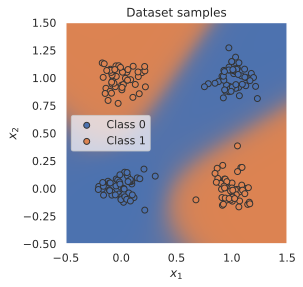

In [ ]:
def visualize_classification(model, data, label):
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    c0 = np.array(to_rgba("C0"))
    c1 = np.array(to_rgba("C1"))
    x1 = jnp.arange(-0.5, 1.5, step=0.01)
    x2 = jnp.arange(-0.5, 1.5, step=0.01)
    xx1, xx2 = jnp.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = np.stack([xx1, xx2], axis=-1)
    logits = model(model_inputs)
    preds = nn.sigmoid(logits)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = jax.device_get(output_image)  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(trained_model, dataset.data, dataset.label)
plt.show()

## Extra

### Vmap and Pmap

In [ ]:
def simple_linear(x, w, b):
    return (x[:, None] * w ).sum(axis=0) + b

In [ ]:
rng, x_rng, w_rng, b_rng = jax.random.split(rng, 4)
x_in = jax.random.normal(x_rng, (4,))
w_in = jax.random.normal(w_rng, (4, 3))
b_in = jax.random.normal(b_rng, (3,))

simple_linear(x_in, w_in, b_in)

Array([ 2.8131008, -2.4916782,  4.96415  ], dtype=float32)

In [ ]:
vectorized_linear = jax.vmap(simple_linear, in_axes=(0, None, None), out_axes=0)

In [ ]:
x_vec_in = jnp.stack([x_in]*5, axis=0)

vectorized_linear(x_vec_in, w_in, b_in)

Array([[ 2.8131008, -2.4916782,  4.96415  ],
       [ 2.8131008, -2.4916782,  4.96415  ],
       [ 2.8131008, -2.4916782,  4.96415  ],
       [ 2.8131008, -2.4916782,  4.96415  ],
       [ 2.8131008, -2.4916782,  4.96415  ]], dtype=float32)

### PyTrees

In [ ]:
parameters = jax.tree_leaves(model_state.params)
print(f"shape of params: {', '.join([str(p.shape) for p in parameters])}")
print(f"Number of params: {sum([np.prod(p.shape) for p in parameters])}")

shape of params: (8,), (2, 8), (1,), (8, 1)
Number of params: 33


In [ ]:
jax.tree_map(
    lambda p : p.shape,
    model_state.params
)

{'params': {'linear1': {'bias': (8,), 'kernel': (2, 8)},
  'linear2': {'bias': (1,), 'kernel': (8, 1)}}}

### Dynamic shapes

In [ ]:
def my_function(x):
    print('Running the function with shape', x.shape)
    return x.mean()

jitted_function = jax.jit(my_function)

In [ ]:
for i in range(10):
    jitted_function(jnp.zeros(i+1,))

Running the function with shape (1,)
Running the function with shape (2,)
Running the function with shape (3,)
Running the function with shape (4,)
Running the function with shape (5,)
Running the function with shape (6,)
Running the function with shape (7,)
Running the function with shape (8,)
Running the function with shape (9,)
Running the function with shape (10,)


In [ ]:
for i in range(10):
    jitted_function(jnp.zeros(i+1,))

> doesn't run the second time, it uses a compiled version